## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Importing Libraries</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler,OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedShuffleSplit
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, accuracy_score,matthews_corrcoef
import scipy
!pip install -q lightgbm==4.5.0
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

  ### <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Loading data</p>

In [2]:
train_data = pd.read_csv(r"/kaggle/input/playground-series-s4e8/train.csv")
test_data = pd.read_csv(r"/kaggle/input/playground-series-s4e8/test.csv")
sample_submission_data = pd.read_csv(r"/kaggle/input/playground-series-s4e8/sample_submission.csv")

print("train_data :", train_data.shape)
print("test_data :", test_data.shape)
print("sample_submission_data :", sample_submission_data.shape)

train_data : (3116945, 22)
test_data : (2077964, 21)
sample_submission_data : (2077964, 2)


In [3]:
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Basic Info about Data</p> 

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [5]:
test_data.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [6]:
sample_submission_data.head()

,id,class
0,3116945,e
1,3116946,e
2,3116947,e
3,3116948,e
4,3116949,e


In [7]:
#train_data = train_data.dropna()
train_data = train_data.drop_duplicates()
train_data.shape

(3116945, 22)

  ### <p style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Percentage of Missing Values by Feature</p>

In [8]:
def null_percent(df):
    per=((df.isnull().sum()/len(df))*100).round(2)
    return per
print("Nan Values in Train data")
print(null_percent(train_data))
print("Nan Values in Test data")
print(null_percent(test_data))

Nan Values in Train data
id                       0.00
class                    0.00
cap-diameter             0.00
cap-shape                0.00
cap-surface             21.53
cap-color                0.00
does-bruise-or-bleed     0.00
gill-attachment         16.81
gill-spacing            40.37
gill-color               0.00
stem-height              0.00
stem-width               0.00
stem-root               88.45
stem-surface            63.55
stem-color               0.00
veil-type               94.88
veil-color              87.94
has-ring                 0.00
ring-type                4.13
spore-print-color       91.43
habitat                  0.00
season                   0.00
dtype: float64
Nan Values in Test data
id                       0.00
cap-diameter             0.00
cap-shape                0.00
cap-surface             21.51
cap-color                0.00
does-bruise-or-bleed     0.00
gill-attachment         16.83
gill-spacing            40.40
gill-color               0.00
stem-h

In [9]:
train_data = train_data.drop(['veil-type','spore-print-color','stem-root','veil-color'], axis=1)
test_data = test_data.drop(['veil-type','spore-print-color','stem-root','veil-color'], axis=1)

In [10]:
num_cols = train_data.select_dtypes(include=['float64']).columns
train_data[num_cols] = train_data[num_cols].fillna(train_data[num_cols].median())
test_data[num_cols] = test_data[num_cols].fillna(test_data[num_cols].median())

In [11]:
train_data.describe()

,id,cap-diameter,stem-height,stem-width
count,3.116945e+06,3.116945e+06,3.116945e+06,3.116945e+06
mean,1.558472e+06,6.309848e+00,6.348333e+00,1.115379e+01
std,8.997847e+05,4.657928e+00,2.699755e+00,8.095477e+00
min,0.000000e+00,3.000000e-02,0.000000e+00,0.000000e+00
25%,7.792360e+05,3.320000e+00,4.670000e+00,4.970000e+00
50%,1.558472e+06,5.750000e+00,5.880000e+00,9.650000e+00
75%,2.337708e+06,8.240000e+00,7.410000e+00,1.563000e+01
max,3.116944e+06,8.067000e+01,8.872000e+01,1.029000e+02


## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Checking Feature Importance</p> 

In [12]:
alpha = 0.05
values = {}

for col in train_data.columns:
    if col == "class":
        continue

    A, B = train_data[col], train_data["class"]

    dfObserved = pd.crosstab(A, B) 
    chi2, p, dof, expected = scipy.stats.chi2_contingency(dfObserved.values)
    values[col] = p
    if p < alpha:
        # Reject null hypothesis
        print("{} is important. (p = {})".format(col, p))
    else:
        # Accept null hypothesis
        print("{} is NOT important. (p = {})".format(col, p))

id is NOT important. (p = 0.4997336950403224)
cap-diameter is important. (p = 0.0)
cap-shape is important. (p = 0.0)
cap-surface is important. (p = 0.0)
cap-color is important. (p = 0.0)
does-bruise-or-bleed is important. (p = 0.0)
gill-attachment is important. (p = 0.0)
gill-spacing is important. (p = 0.0)
gill-color is important. (p = 0.0)
stem-height is important. (p = 0.0)
stem-width is important. (p = 0.0)
stem-surface is important. (p = 0.0)
stem-color is important. (p = 0.0)
has-ring is important. (p = 0.0)
ring-type is important. (p = 0.0)
habitat is important. (p = 0.0)
season is important. (p = 0.0)


class
p    1705396
e    1411549
Name: count, dtype: int64


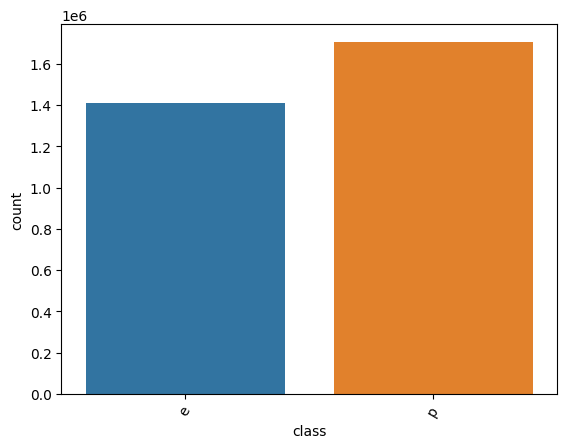

In [13]:
print(train_data['class'].value_counts())
sns.countplot(x='class',data=train_data)
plt.xticks(rotation=60)
plt.show()

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Filling NaN Values</p> 

In [14]:
cat_cols = list(train_data.select_dtypes(include=['object']).columns.difference(['class']))

for col in cat_cols:
    mode_value = train_data[col].mode()[0]
    train_data[col].fillna(mode_value, inplace=True)
    
for col in cat_cols:
    mode_value = train_data[col].mode()[0]
    test_data[col].fillna(mode_value, inplace=True)

In [15]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_data[cat_cols] = encoder.fit_transform(train_data[cat_cols])
test_data[cat_cols] = encoder.transform(test_data[cat_cols])

In [16]:
labelencoder = LabelEncoder()
train_data['class'] = labelencoder.fit_transform(train_data['class'])

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Correlation Matrics</p> 

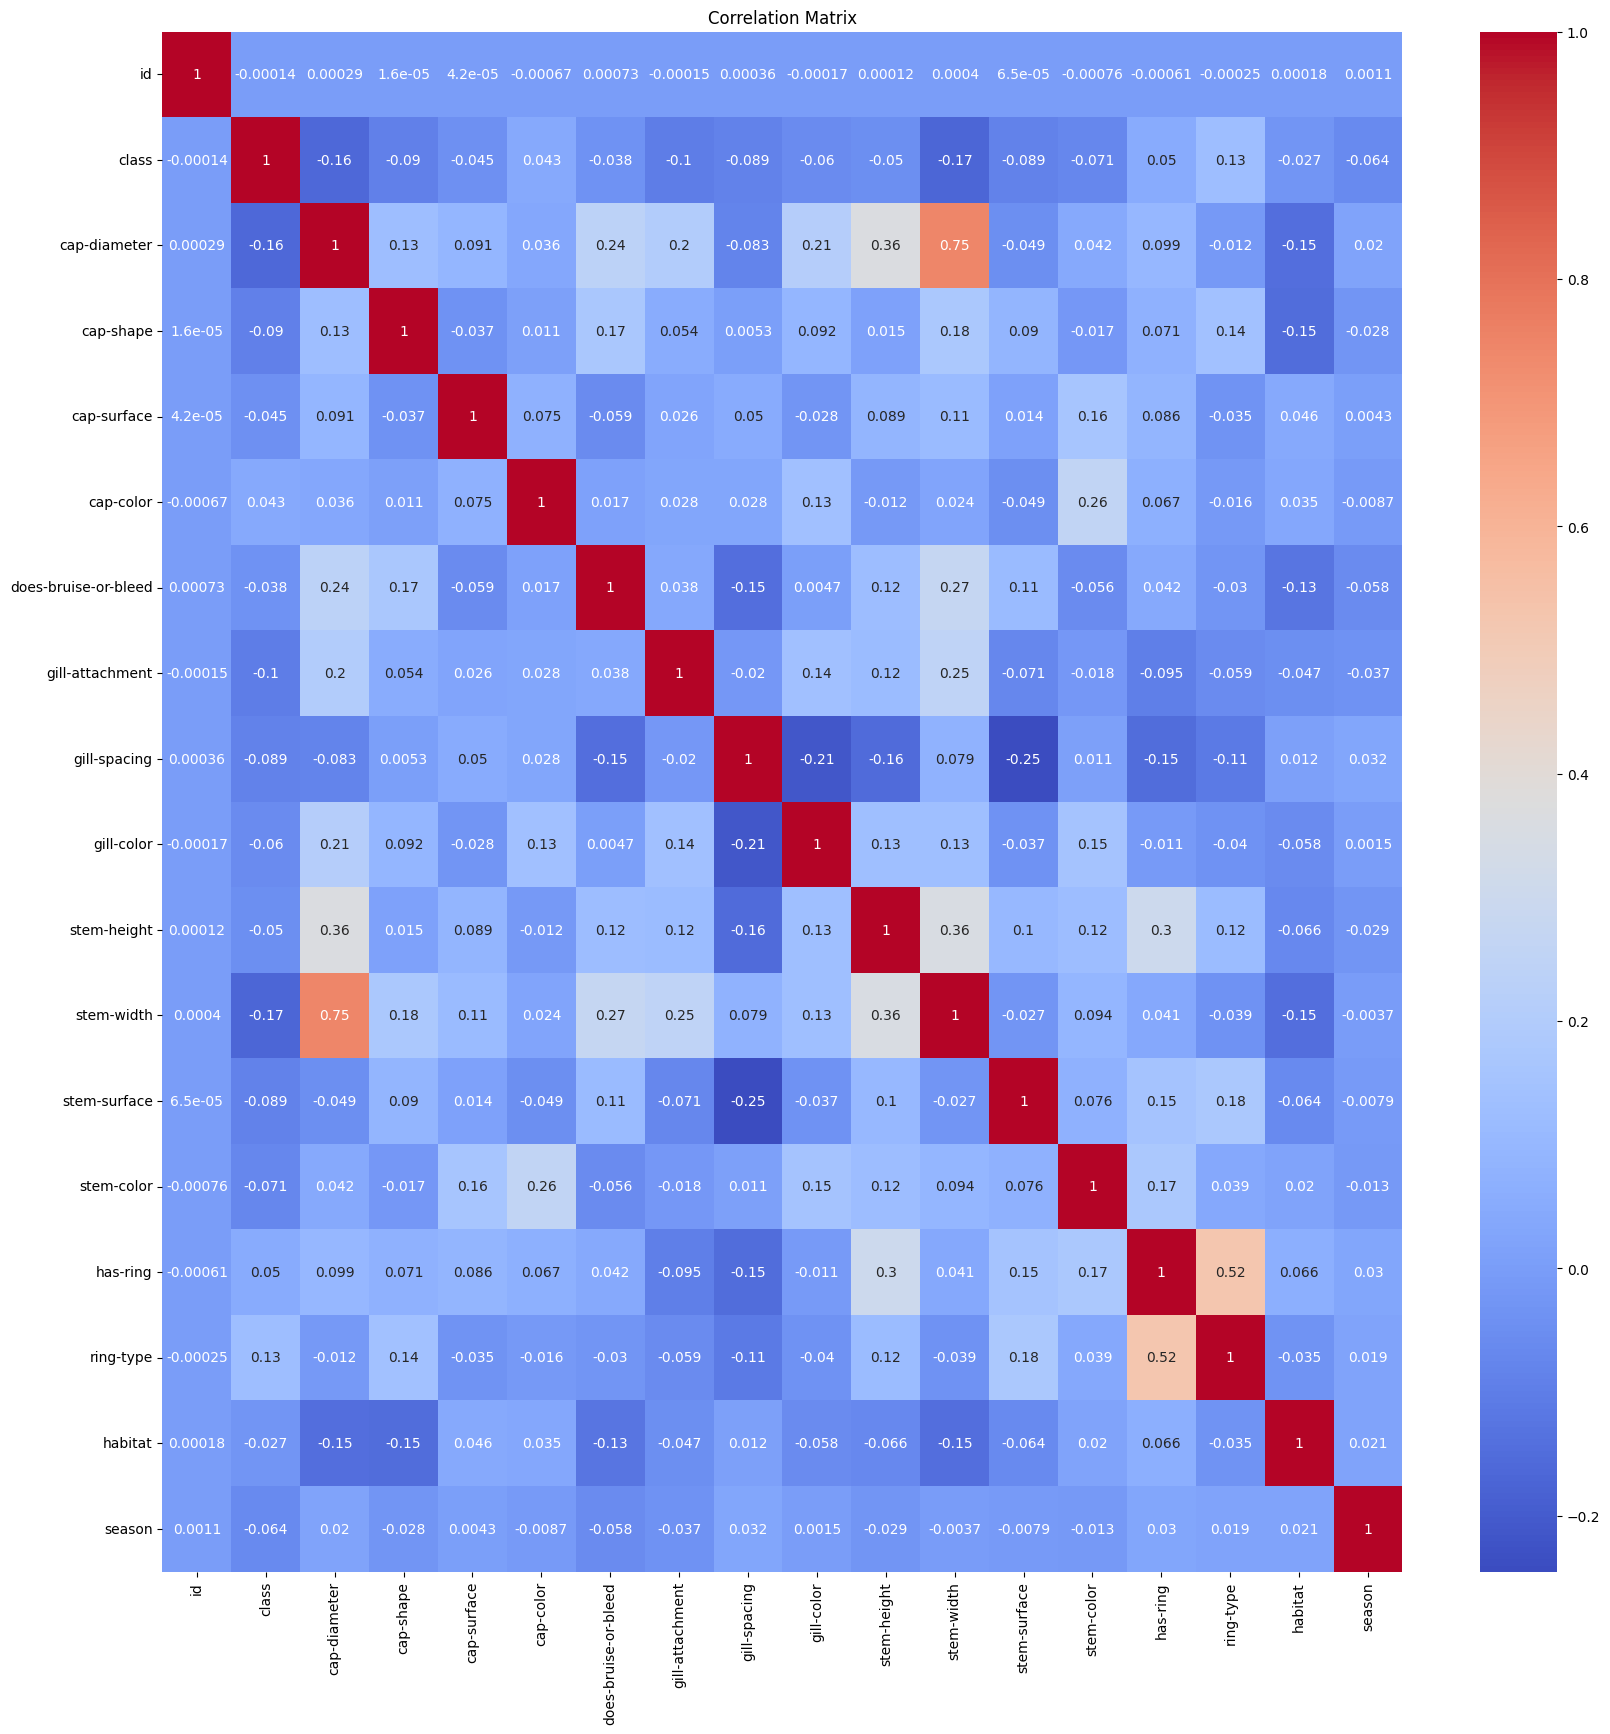

In [17]:
df_dropped = train_data.dropna()

# Encode categorical variables
df_encoded = df_dropped.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x)

# Compute the correlation matrix
correlation_matrix = df_encoded.corr()

# Visualize the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [18]:
train_data.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season
0,0,0,8.80,53.0,72.0,72.0,8.0,44.0,28.0,59.0,4.51,15.39,51.0,55.0,5.0,18.0,25.0,0.0
1,1,1,4.51,71.0,56.0,64.0,8.0,44.0,28.0,46.0,4.79,6.48,58.0,47.0,18.0,39.0,25.0,3.0
2,2,0,6.94,53.0,72.0,49.0,8.0,75.0,28.0,59.0,6.85,9.93,51.0,46.0,5.0,18.0,36.0,3.0
3,3,0,3.88,53.0,81.0,57.0,8.0,70.0,28.0,37.0,4.16,6.53,51.0,55.0,5.0,18.0,25.0,2.0
4,4,0,5.85,71.0,65.0,74.0,8.0,47.0,28.0,59.0,3.37,8.36,51.0,55.0,5.0,18.0,29.0,0.0


## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Splitting Data</p> 

In [19]:
X = train_data.drop(['id','class'], axis=1)
y = train_data['class']
test = test_data.drop(['id'], axis=1)
X.shape,y.shape

((3116945, 16), (3116945,))

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Using XGBoost with optuna</p> 

In [20]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the objective function for Optuna
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 20),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
#         'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1.0, 10.0)
#     }
    
#     model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     mcc = matthews_corrcoef(y_test, y_pred)
#     trial.set_user_attr("mcc", mcc)
#     return mcc

# # Callback to print the MCC score for each trial
# def print_mcc_callback(study, trial):
#     mcc = trial.user_attrs["mcc"]
#     print(f"Trial {trial.number}: MCC = {mcc}")

# # Optimize hyperparameters with Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100, callbacks=[print_mcc_callback])

# # Get the best parameters
# best_params = study.best_params
# print(f"Best parameters: {best_params}")

# # Train final model with best hyperparameters
# final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
# final_model.fit(X_train, y_train)

# # Predict and evaluate the final model
# y_pred = final_model.predict(X_test)
# mcc = matthews_corrcoef(y_test, y_pred)
# print(f"Matthews Correlation Coefficient: {mcc}")
# preds = final_model.predict(test)
# predictions = labelencoder.inverse_transform(preds)

# submission = pd.DataFrame({'id': test_data.id, 'class': predictions})
# submission.to_csv('submission_by_ideal_param.csv', index=False)


## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">After running Above code the best param are :</p>
### <pre style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Trial 99: MCC = 0.9834100510827682</pre>
### <pre style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff"> Best parameters: {'n_estimators': 432, 'max_depth': 18, 'learning_rate': 0.019177494166556952, 'subsample': 0.6944494028059239, 'colsample_bytree': 0.5177980824894136, 'gamma': 0.0004342336537981622, 'lambda': 1.3527652792856453e-06, 'alpha': 4.10797226500692e-08, 'scale_pos_weight': 1.0121323580230017}</pre>
### <pre style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Matthews Correlation Coefficient: 0.9834331462863742</pre>
 

In [21]:
parameters ={'n_estimators': 432, 'max_depth': 18, 'learning_rate': 0.019177494166556952, 'subsample': 0.6944494028059239, 'colsample_bytree': 0.5177980824894136, 'gamma': 0.0004342336537981622, 'lambda': 1.3527652792856453e-06, 'alpha': 4.10797226500692e-08, 'scale_pos_weight': 1.0121323580230017}


In [22]:
# from sklearn.metrics import matthews_corrcoef, confusion_matrix
# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # Train XGBClassifier on the undersampled data
# model = XGBClassifier(**parameters)
# model = model.fit(X_train, y_train)

# # Predict and evaluate the model
# y_pred = model.predict(X_test)
# # Calculate MCC
# mcc = matthews_corrcoef(y_test, y_pred)
# print(f"Matthews Correlation Coefficient: {mcc}")

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Saving Submission file Using XGBoost</p>

In [23]:
# preds = model.predict(test)
# predictions = labelencoder.inverse_transform(preds)

# submission = pd.DataFrame({'id': test_data.id, 'class': predictions})
# submission.to_csv('submission_by_xgb.csv', index=False)


In [24]:
# submission['class'].value_counts()

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Using LGBM</p> 

In [25]:
# import optuna
# import lightgbm as lgb
# from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.metrics import matthews_corrcoef
# import pandas as pd

# # Function to create LightGBM dataset
# def create_lgb_dataset(X, y, test_size=0.17, random_state=42):
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
#     for train_index, val_index in sss.split(X, y):
#         X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#         y_train, y_val = y.iloc[train_index], y.iloc[val_index]
#     train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
#     val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, free_raw_data=False)
#     return train_data, val_data, X_val, y_val

# # Objective function for Optuna
# def objective(trial):
#     params = {
#         'objective': 'binary',
#         'metric': 'auc',
#         'device_type': 'cpu',
#         'boosting_type': 'gbdt',
#         'num_leaves': trial.suggest_int('num_leaves', 31, 1024),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 0.9),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 0.9),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'max_depth': trial.suggest_int('max_depth', 1, 50),
#         'max_bin': trial.suggest_int('max_bin', 255, 100000),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 10000)
#     }

#     # Create LightGBM dataset
#     train_data, val_data, X_val, y_val = create_lgb_dataset(X, y)

#     # Train the model
#     bst = lgb.train(
#         params,
#         train_data,
#         num_boost_round=1500,
#         valid_sets=[val_data],
#         callbacks=[lgb.early_stopping(stopping_rounds=27), lgb.log_evaluation(50)]
#     )

#     # Predict validation data
#     y_pred = bst.predict(X_val)
#     y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
    
#     # Calculate MCC
#     mcc = matthews_corrcoef(y_val, y_pred_binary)
#     return mcc

# # Create Optuna study and optimize
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Best hyperparameters
# best_params = study.best_trial.params
# print(f"Best parameters: {best_params}")

# # Assuming X_train, y_train, X_test, y_test, and test_data are defined earlier in your code
# # Train final model with best hyperparameters
# final_model = lgb.LGBMClassifier(**best_params)
# final_model.fit(X, y)



## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">After running Above code the best param are :</p>
### <pre style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff"> Best Parameters: {'num_leaves': 989,'learning_rate': 0.01150197154409214, 'feature_fraction': 0.6153388926958593, 'bagging_fraction' :0.830726975975083, 'bagging_freq': 7, 'lambda_11': 9.285703159386265e-05, 'lambda_12': 3.5283439660576336e-08,'max_depth': 19, 'max_bin': 60481, 'n_estimators': 2026}.</pre>
### <pre style="background-color: #fdefff;color:#c12eff;display: inline-block;padding:.6rem;border-radius:.5rem;border: 1px solid #c059ff">Matthews Correlation Coefficient:.983870 </pre>
 

In [26]:
params={'num_leaves': 989,'metric':'auc','learning_rate': 0.01150197154409214, 'feature_fraction': 0.6153388926958593, 'bagging_fraction' :0.830726975975083, 'bagging_freq': 7, 'lambda_l1': 9.285703159386265e-05, 'lambda_l2': 3.5283439660576336e-08,'max_depth': 19, 'max_bin': 60481, 'n_estimators': 2026}

In [27]:
# Create the LightGBM dataset
train_dataset = lgb.Dataset(X, label=y)

# Train the model
model = lgb.train(params, train_dataset, num_boost_round=1500)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7936
[LightGBM] [Info] Number of data points in the train set: 3116945, number of used features: 16
[LightGBM] [Info] Start training from score 0.547137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

## <p style="background-color:#d8ecff; color: #009dff;margin:0; display:inline-block;padding:.4rem;border-radius:.25rem;border:1px solid #009dff">Saving Submission file Using LGBM</p>

In [28]:
# Assuming 'test_data' is the test data with features only
X_test = test_data.drop('id', axis=1)
preds = model.predict(X_test)

# Check the prediction values
print("Predicted values:", preds)

# Convert probabilities to binary class labels using a threshold
threshold = 0.5
discrete_preds = (preds >= threshold).astype(int)

# Check the unique values in discrete_preds
print("Unique values in discrete_preds:", np.unique(discrete_preds))

# Ensure the label encoder was fitted correctly
print("Classes in labelencoder:", labelencoder.classes_)

# Convert binary class labels back to original class labels
predictions = labelencoder.inverse_transform(discrete_preds)

# Check the unique values in predictions
print("Unique values in predictions:", np.unique(predictions))

# Create a submission DataFrame
submission = pd.DataFrame({'id': test_data['id'], 'class': predictions})
submission.to_csv('submission_by_LGBM.csv', index=False)


Predicted values: [ 0.00778084  1.00302566  0.98750179 ...  0.99588    -0.00219815
 -0.01013022]
Unique values in discrete_preds: [0 1]
Classes in labelencoder: ['e' 'p']
Unique values in predictions: ['e' 'p']



### <p style="background-color: #fdefff;color:#c12eff;margin: 0;display: inline-block;padding:.4rem;border-radius:.5rem;border: 1px solid #c059ff">Please Upvote if you Really liked this</p>